In [8]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from fastai.data.transforms import get_image_files, get_files
from fastai.vision.data import SegmentationDataLoaders
import os
from os import path
from fastseg.image import colorize, blend
from PIL import Image
from tqdm import tqdm
import albumentations as A
import math
from fastai.vision.all import Learner
from fastai.metrics import DiceMulti
from fastseg import MobileV3Small

root_dir = "/media/nevin/Trash Games1/culane/"
base_dir = "/media/nevin/Trash Games1/culane/driver_23_30frame"
processed_dir = "/media/nevin/Trash Games1/culane/augmented"

5284


In [15]:
input_images = get_image_files(path.join(processed_dir, "images/"))

codes = ["lane"]

def label_func(input):
    return f"{processed_dir}/labels/{input.stem}.png"

print(label_func(input_images[0]))

dls = SegmentationDataLoaders.from_label_func(
    root_dir,
    input_images,
    label_func=label_func,
    codes=codes,
    bs=4,
)


/media/nevin/Trash Games1/culane/augmented/labels/00000.png


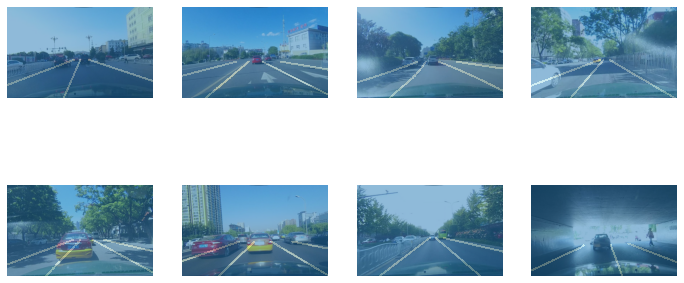

In [7]:
dls.show_batch(max_n=8)

In [16]:
model = MobileV3Small(num_classes=2, use_aspp=True)
learn = Learner(dls, model, metrics=[DiceMulti()])

In [17]:
learn.fine_tune(1)

epoch,train_loss,valid_loss,dice_multi,time


/home/nevin/.local/lib/python3.10/site-packages/geffnet/activations/activations_me.py:157: UserWarning: FALLBACK path has been taken inside: runCudaFusionGroup. This is an indication that codegen Failed for some reason.
To debug try disable codegen fallback path via setting the env variable `export PYTORCH_NVFUSER_DISABLE=fallback`
 (Triggered internally at  ../torch/csrc/jit/codegen/cuda/manager.cpp:334.)
  return hard_swish_jit_fwd(x)


RuntimeError: The following operation failed in the TorchScript interpreter.
Traceback of TorchScript (most recent call last):
RuntimeError: The following operation failed in the TorchScript interpreter.
Traceback of TorchScript (most recent call last):
  File "/home/nevin/.local/lib/python3.10/site-packages/geffnet/activations/activations_me.py", line 142, in fallback_cuda_fuser
@torch.jit.script
def hard_swish_jit_fwd(x):
    return x * (x + 3).clamp(min=0, max=6).div(6.)
                ~~~~~ <--- HERE
RuntimeError: CUDA out of memory. Tried to allocate 24.00 MiB (GPU 0; 7.92 GiB total capacity; 6.58 GiB already allocated; 101.44 MiB free; 6.61 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF



In [34]:
dirs = os.listdir(base_dir)

output = []

for dir in dirs:
    dir = path.join(base_dir, dir)
    images = get_image_files(dir)
    step = math.floor(len(images) / 14)
    if step == 0:
        continue
    for i in range(0, len(images), step):
        output.append(images[i])

# print(len(output))
print(len(output))

def get_points(label_file):
    with open(label_file) as file:
        lines = file.readlines()
        lines = [line.rstrip() for line in lines]

    points = [[] for line in lines]
    for idx, line in enumerate(lines):
        split = line.split(" ")
        for i in range(0, len(split), 2):
            points[idx].append([int(float(split[i])), int(float(split[i + 1]))]) # it works
    
    return np.array(points, dtype=object)


def gen_seg(image, points):
    h, w, c = image.shape
    seg_image = np.zeros((h, w), np.uint8)
    for i in range(len(points)):
        point = np.asarray(points[i])
        x = point[:, 0]
        y = point[:, 1]

        draw_points = (np.asarray([x, y]).T).astype(np.int32)

        seg_image = cv.polylines(seg_image, [draw_points], False, color=(1, 0, 0), thickness=10)
    
    return seg_image


for image in tqdm(output):
    img_save_path = os.path.join(processed_dir, "images/", image.name)
    seg_save_path = os.path.join(processed_dir, "labels/", f"{image.stem}.png")
    label_path = f"{image.parent}/{image.stem}.lines.txt"

    img = cv.imread(str(image))
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    points = get_points(label_path)
    seg_mask = gen_seg(img, points)

    # maybe don't do this for data augmentation later but for now it's fine
    img = img[0:500, 400:1200]
    seg_mask = seg_mask[0:500, 400:1200]

    width = int(img.shape[1] * 0.21)
    height = int(img.shape[0] * 0.21)

    img = cv.resize(img, (width, height), interpolation=cv.INTER_AREA)
    seg_mask = cv.resize(seg_mask, (width, height), interpolation=cv.INTER_AREA)

    img = Image.fromarray(img)
    img.save(img_save_path)

    seg_mask = Image.fromarray(seg_mask)
    seg_mask.save(seg_save_path)

5284


100%|██████████| 5284/5284 [09:36<00:00,  9.16it/s]  
